In [4]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import numpy as np

In [5]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA200.tsp':'kroA200.tsp', '../kroB200.tsp':'kroB200.tsp'}
properties=systematize(file_namez)

In [6]:
def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def modern_exchange(self, preve, nexte, vertexes):
        past_preve=self.prev
        past_nexte=self.next
        
        self.exchange(preve, nexte)
        if self.present==False:
            vertexes[past_preve].next=past_nexte
            vertexes[past_nexte].prev=past_preve
        else:
            vertexes[preve].next=self.value
            vertexes[nexte].prev=self.value
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'

In [7]:
class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _get_maxes(self, v1, v2):
        if self._maxes[0]['place']==v1 or self._maxes[0]['place']==v2:
            if self._maxes[1]['place']==v1 or self._maxes[1]['place']==v2:
                return self._maxes[2]
            return self._maxes[1]
        return self._maxes[0]
    
    def _formulate_maxes(self):
        maxes=[]
        for x in self.vertexes:
            if x.present==False:
                continue
            maxes.append({'value':self.matrix[x.prev][x.value]+self.matrix[x.value][x.next]-self.matrix[x.prev][x.next], 'place':x.value})
        self._maxes=sorted(maxes, key=lambda x: x['value'], reverse=True)[:3]
        
            
    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit); only one present
    def _cost_swap_vertex(self, v1, v2, bastard='None'):
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=self._get_maxes(v1, next1)['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        
        if bastard=='None':
            return max(eld-neue, -novel)
        if bastard=='Close':
            return -novel
        if bastard=='Distant':
            return -neue
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2, bastard='None'):
        if self.vertexes[v1].present==False: #v1 exists always
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        reason=self._get_maxes(v1, next1)
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=reason['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        if (-novel > eld-neue and bastard!='Distant') or bastard=='Close':
            nel=next1
        else:
            nel=reason['place']
        
        self.vertexes[v2].modern_exchange(v1, next1, self.vertexes)
        self.vertexes[nel].modern_exchange(-1, -1, self.vertexes)
    
    def _swap_by_vertex(self, v1, v2):
        self._swap_partial(v1, v2)
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2, formal_dissolver=False):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        if formal_dissolver==True:
            neue=self.matrix[v2][next1]+self.matrix[v1][next2]
            eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return None
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        else:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
                        
            
    def steep(self):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in range(i+1, len(self.matrix)):
                    coste, fun=self._get_properties(i, j)
                    
                    if coste<max_gain:
                        continue
                    max_gain=coste
                    vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            self._formulate_maxes()
            
    def greed(self):
        while True:
            changed=False
            rn1=get_some_randomness(0, len(self.matrix), len(self.matrix))
            rn2=get_some_randomness(0, len(self.matrix), len(self.matrix))
            max_gain=0
            
            for i in rn1:
                for j in rn2:
                    if j>=i:
                        continue
                    coste, fun=self._get_properties(i, j)
                    if coste<=0:
                        continue
                    changed=True
                    self.current_cost-=coste
                    fun(i, j)
                    self._formulate_maxes()
            if changed==False:
                return
            
    
    def execute_optimizer(self, name='greed', params=[]):
        _methods={
            'greed':self.greed,
            #'steep':self.steep,
            #'steep_candid':self.steep_candid,
            #'steep_heap':self.steep_heapov
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args=['random'], start=-1, pathway=None):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random',
            'given':'given'
        }
        self.halfway=len(matrix)//2
        self._full_len=len(matrix)
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        elif method=='given':
            self.pathway=pathway
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
        self._formulate_maxes()

In [8]:
class Population:
    def find_trail(self, path1, x1, path2, x2): #path1[x1]==path2[x2]
        x, nx=path1[x1], path1[(x1+1)%len(path1)]
        pathway=[path1[x1]]
        
        if nx==path2[(x2-1)%len(path2)]:
            diff=-1
        elif nx==path2[(x2+1)%len(path2)]:
            diff=1
        else:
            return pathway
        
        i=(x2+diff)%len(path2)
        j=(x1+1)%len(path1)
        while j!=x1:
            if path2[i]!=path1[j]:
                return pathway
            pathway.append(path1[j])            
            i=(i+diff)%len(path2)
            j=(j+1)%len(path1)
        return pathway
    
    def check_equivalent(self, path1, path2):
        x, nx=path1[0], path1[1]
        pos=-1
        for i,y in enumerate(path2):
            if y==x:
                pos=i
                break
        if pos==-1:
            return False
        
        f=self.find_trail(path1, 0, path2, pos)
        if (len(f)!=len(path1)):
            return False
        return True
    
    def find_suitable(self, unsuitable, meta_parents=4):
        beste=-1
        bad=[False]*self.pop_size
        for x in unsuitable:
            bad[x]=True
            
        for i in range(meta_parents):
            while True:
                h=np.random.randint(self.pop_size)
                if bad[h]==False:
                    bad[h]=True
                    break
            if beste==-1 or self.population[h]['cost'] < self.population[beste]['cost']:
                beste = h
        return h
        
        
    def find_two_parents(self):
        x=self.find_suitable([])
        y=self.find_suitable([x])
        return x, y
        
    def mutate(self, path, mutations=8):
        for _ in range(mutations):
            a, b=np.random.randint(self.full_len), np.random.randint(self.full_len)
            h, fun=path._get_properties(a, b)
            if fun!=-1:
                fun(a, b)
                path._formulate_maxes()
    
    def add_path(self, path):
        for x in self.population:
            if self.check_equivalent(path.pathway, x['path']):
                return
            
        self.population.append({'path':path.pathway, 'cost':path.cost()})
        minne=max([x['cost'] for x in self.population])
        erase=-1
        
        for i,x in enumerate(self.population):
            if x['cost']==minne:
                erase=i
                break
                
        self.population.pop(erase)
        
    def recombined(self, path1, path2):
        n=self.full_len
        ind1=[-1]*n
        ind2=[-1]*n
        slain=[False]*n
        trails=[]
        summa=0
        
        for i,x in enumerate(path1):
            ind1[x]=i
        for i,x in enumerate(path2):
            ind2[x]=i
        for i,x in enumerate(path1):
            if ind2[x]!=-1 and slain[x]==False:
                trail=self.find_trail(path1, i, path2, ind2[x])
                
                pos=-1
                for i,x in enumerate(trail):
                    if slain[x]==True:
                        pos=i
                        break
                    slain[x]=True
                if pos>-1:
                    trail=trail[:pos]
                
                trails.append(trail)
                summa+=len(trail)
        print(summa)
        
        for i in range(summa, len(path1)):
            while True:
                x=np.random.randint(n)
                if slain[x]==False:
                    break
            slain[x]=True
            trails.append([x])
            
        random.shuffle(trails)
        finale=[]
        for x in trails:
            finale.extend(x)
        return Pathway(self.matrix, constr_method_and_args=['given'], pathway=finale)
                
    
    def optimizer(self, zeit):
        t_start=time.time()
        
        while time.time()-t_start<zeit:
            x, y=self.find_two_parents()
            path=self.recombined(self.population[x]['path'], self.population[y]['path'])
            self.mutate(path)
            path.execute_optimizer()
            self.add_path(path)
            
            
    def __init__(self, matrix):
        self.pop_size=20
        self.population=[]
        self.matrix=matrix
        self.full_len=len(matrix)
        
        for i in range(self.pop_size):
            while True:
                path=Pathway(matrix)
                path.execute_optimizer()
                
                equiv=False
                for y in self.population:
                    if self.check_equivalent(path.pathway, y['path']):
                        equiv=True
                        break
                if equiv==False:
                    self.population.append({'path':path.pathway, 'cost':path.cost()})
                    break

In [9]:
pop=Population(properties['kroA200.tsp']['matrix'])

In [10]:
lst=[x['cost'] for x in pop.population]
print(lst, sum(lst)/len(lst))

[13302, 14706, 14299, 15008, 15130, 14212, 14503, 14609, 13570, 15224, 13924, 14984, 13326, 15218, 13805, 14401, 14595, 15921, 15015, 14627] 14518.95


In [11]:
pop.optimizer(100)

63
63
70
53
58
56
70
60
66
59
63
68
72
70
71
64
79
63
66
55
77
62
67
66
69
69
50
75
70
73
70
72
66
65
73
61
61
62
59
67
76
64
67
74
65
76
71
73
73
67
70
62
59
66
60
65
65
69
72
59
69
73
71
62
68
69
59
68
69
78
74
60
70
62
64
57
71
57
71
73
72
70
76
74
68
55
78
75
60
78
70
64
68
62
78
79
76
73
83
59
85
79
85
75
64
73
72
76
79
81
65
77
75
64
72
85
73
73
91
61
75
71
63
77
75
68
79
79
71
78
84
76
66
72
74
68
80
85
90
75
63
75
77
77
83
80
86
78
72
78
78
74
68
71
73
73
78
79
78
79
75
81
79
73
73
81
71
78
67
69
72
77
77
88
72
70
72
71
82
82
74
65
70
65
83
77
81
66
77
68
73
83
84
79
87
70
73
82
72
85
77
84
76
88
72
71
76
83
76
80
83
82
79
79
77
75
76
85
84
80
72
72
90
80
84
72
79
79
84
81
80
77
87
76
82
87
84
82
76
84
77
72
83
91
89
72
74
71
82
82
79
76
85
87
83
82
85
83
73
86
78
77
83
67
91
84
89
79
75
91
85
84
88
82
90
85
77
75
85
83
88
78
79
85
83
82
79
81
89
81
91
87
96
85
78
78
83
85
91
91
81
90
78
87
87
81
86
79
88
78
84
81
75
81
78
86
92
91
67
90
85
92
69
89
96
75
89
83
87
82
79
88
90
8

In [12]:
lst=[x['cost'] for x in pop.population]
print(lst, sum(lst)/len(lst), min(lst))

[12808, 12733, 12727, 12750, 12727, 12694, 12773, 12727, 12724, 12782, 12771, 12715, 12721, 12784, 12751, 12768, 12795, 12792, 12719, 12779] 12752.0 12694


In [13]:
print(pop.population[0]['path']==pop.population[1]['path'])
print(pop.check_equivalent(pop.population[0]['path'], pop.population[1]['path']))

False
False


In [16]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0
        
#reality=[('ils2a', [ils2, False, True])]

system={}
neo_zeit={'kroA200.tsp':15.31, 'kroB200.tsp':15.71}

iters=10
for falka in range(iters):
    print(f'iteracja nr {falka}')
    for x in properties:
        matrix=properties[x]['matrix']
        post_neo_zeit=neo_zeit[x]
        t1=time.time()
        pop=Population(matrix)
        post_neo_zeit=post_neo_zeit-(time.time()-t1)
        pop.optimizer(post_neo_zeit)
        t2=time.time()-t1

        if (x, 'evolution') not in system:
            create_fields(system, (x, 'evolution'), ['res', 'time'])
            
        lst=[ss['cost'] for ss in pop.population]
        min_lst=min(lst)
        
        for ss in pop.population:
            if ss['cost']==min_lst:
                element=ss
                break
        
        append_later(system[(x, 'evolution')], element['cost'], element['path'], t2, iters)

iteracja nr 0
64
62
57
70
56
67
60
62
63
68
55
63
55
62
62
60
73
50
61
61
61
67
57
65
61
60
68
67
72
62
64
72
66
67
67
63
65
70
69
63
64
70
69
73
67
64
70
63
66
65
57
75
57
64
75
74
81
64
73
64
76
75
71
74
75
70
72
68
60
75
65
68
79
67
62
69
64
69
65
73
67
74
65
76
64
70
67
76
68
66
78
61
72
60
67
66
67
67
58
57
72
57
68
61
73
72
66
51
63
73
72
55
61
51
67
58
65
65
69
58
73
71
66
63
71
74
71
56
75
69
77
73
62
61
82
70
62
68
82
74
70
77
68
75
72
75
67
62
71
58
64
75
75
58
81
70
69
64
70
74
74
80
58
79
76
74
73
58
70
70
85
62
70
56
79
85
78
71
73
62
70
64
56
70
73
76
70
69
74
80
81
iteracja nr 1
66
53
79
62
57
68
62
73
54
70
64
65
62
65
66
61
68
68
62
71
70
61
76
66
73
60
80
74
65
69
69
72
68
74
73
72
73
70
61
70
76
74
70
69
71
77
61
69
68
69
67
74
78
75
79
63
77
69
64
77
70
60
67
73
87
72
88
64
68
70
66
78
68
68
73
68
82
62
71
62
72
71
72
73
77
87
81
62
78
81
83
85
66
70
70
82
67
72
71
66
63
65
67
74
67
65
61
72
69
66
67
74
77
78
70
61
65
76
72
71
72
72
62
60
75
72
61
71
76
60
80
73
69


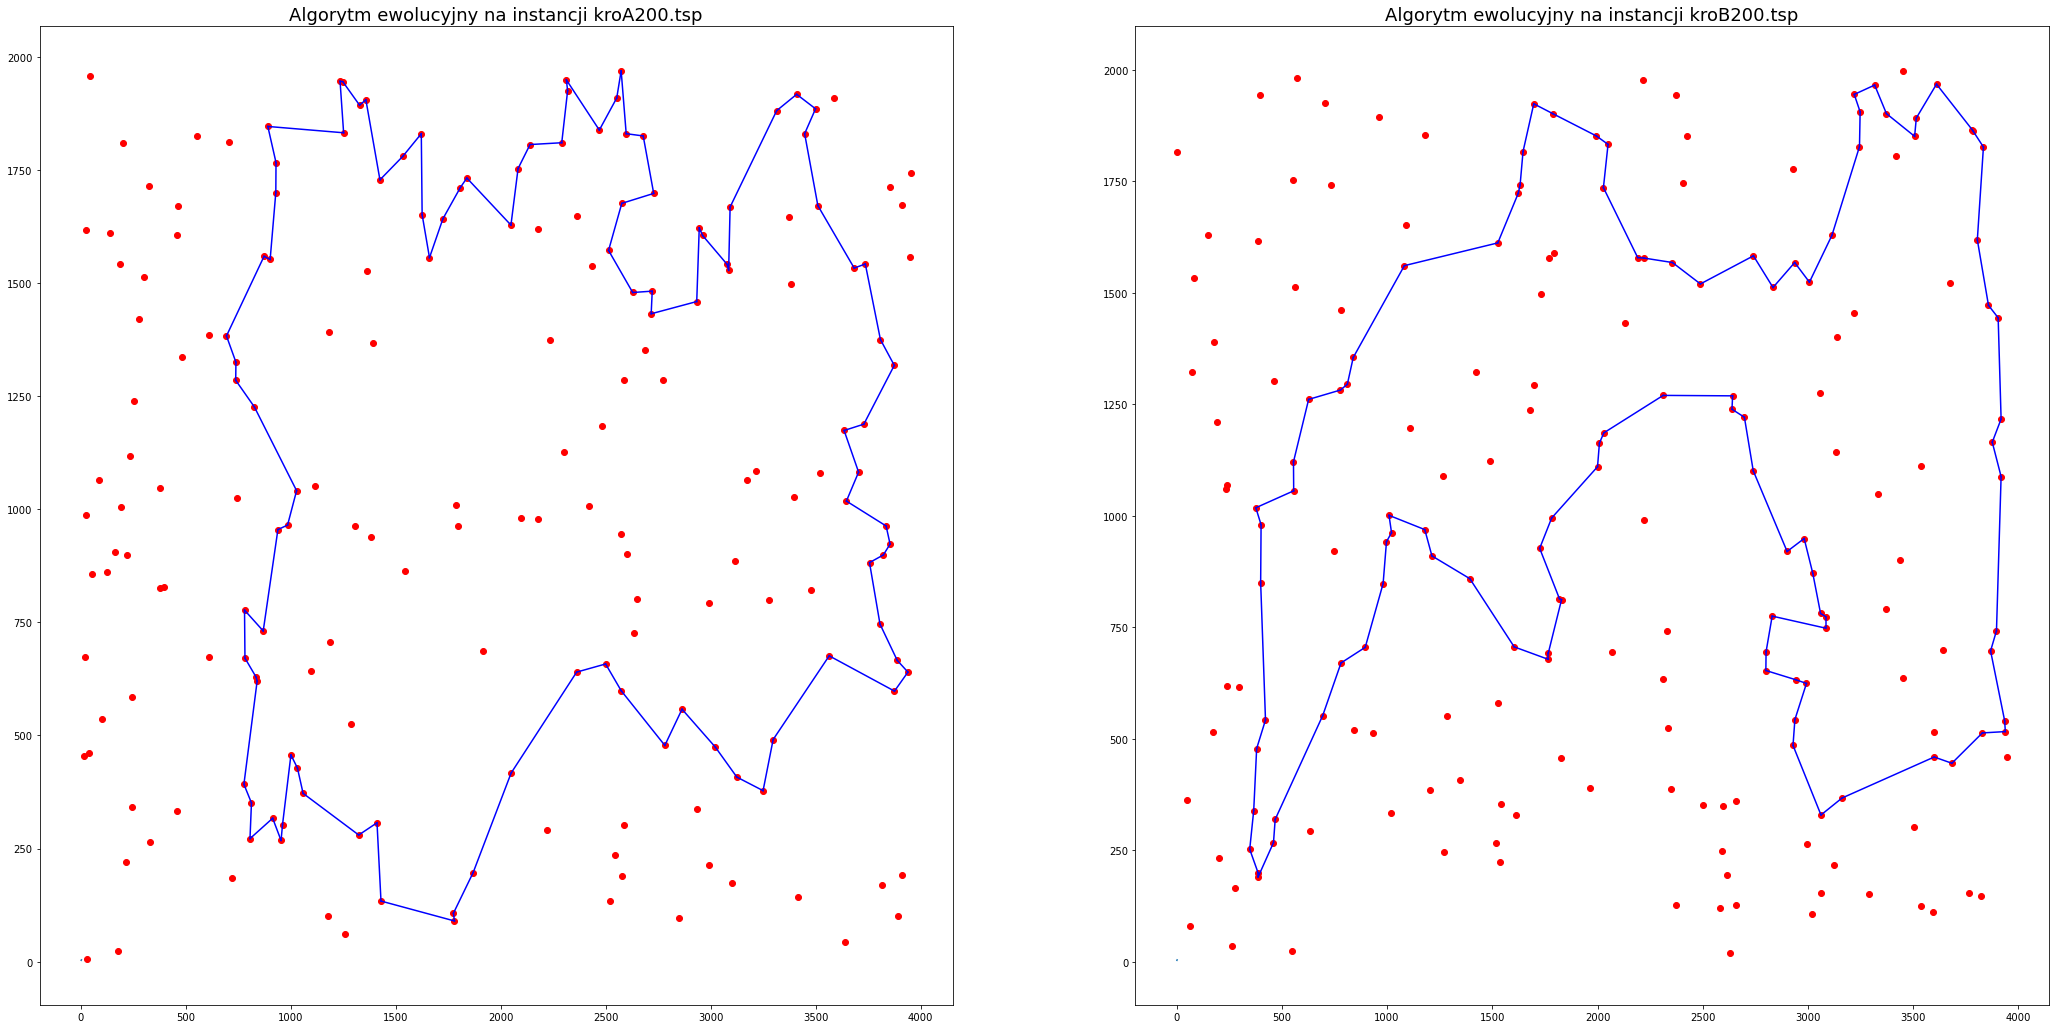

In [22]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA200.tsp':0, 'kroB200.tsp':1, 
      'evolution':0}

naming={'evolution':'ewolucyjny'}

typic=18
plots=1
fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
if plots==1:
    ax=[ax]

for x in system:
    col=mapp[x[0]]
    row=mapp[x[1]]
    print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
    ax[row][col].set_title(f'Algorytm {naming[x[1]]} na instancji {x[0]}', size=18)
plt.savefig(f"heury.svg", bbox_inches="tight")

In [24]:
neo_naming={
    'evolution':('ewolucyjny', '-')
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[1]][0]} & {neo_naming[x[1]][1]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

kroA200.tsp & ewolucyjny & - & 12896.00 & 13444.00 & 13061.00 & 15.32 & 15.43 & 15.37\\ \hline
kroB200.tsp & ewolucyjny & - & 12812.00 & 13070.00 & 12944.70 & 15.72 & 15.83 & 15.76\\ \hline


In [112]:
print(system_starter)

{('kroA200.tsp', 'random'): {'min_res': 156473, 'max_res': 181230, 'avg_res': 163404.0}, ('kroB200.tsp', 'random'): {'min_res': 149016, 'max_res': 175515, 'avg_res': 165315.50000000003}}


In [8]:
import heapq

h = []
heapq.heappush(h, (5, {'a':['write code', "BENIZZII"], 'b':312}))
heapq.heappush(h, (7, 'release product'))
heapq.heappush(h, (1, 'write spec'))
heapq.heappush(h, (3, 'create tests'))
falka=heapq.heappop(h)
print(h, falka)

[(3, 'create tests'), (7, 'release product'), (5, {'a': ['write code', 'BENIZZII'], 'b': 312})] (1, 'write spec')
